## 챗봇 만들기

이번프로젝트에서는 한국어데이터로  챗본을 구현해보겠다. 한국어 챗봇 데이터는 송영숙님이 공개한 [데이터](https://github.com/songys/Chatbot_data)를 사용했다.


 - [ChatBotData.csv](https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv) : 챗봇 트레이닝용 문답 페어 11,876개
 -  다음카페 "사랑보다 아름다운 실연( http://cafe116.daum.net/_c21_/home?grpid=1bld )"에서 자주 나오는 이야기들을 참고하여 제작하였다고함.
 - 연애나 일상이야기위주로 데이터셋이 구성된것을 확인할 수 있다.  
  - 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링
 
---
관련 라이브러리를 로드하고 데이터셋부터 설정해보겠다.


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd


## 챗봇의 병렬 데이터 받아오기




### 데이터 로드

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')

train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


질문과 답변데이터로 깔끔하게 정리되어있는 데이터를 확인할 수 있다.

In [ ]:
print('챗봇 데이터 샘플의 개수 :', len(train_data))
print('결측값이 있는 샘플값의 갯수:', train_data.isnull().sum())

챗봇 데이터 샘플의 개수 : 11823
결측값이 있는 샘플값의 갯수: Q        0
A        0
label    0
dtype: int64


한국어 챗봇의 샘플 문장은 1만 천여건이며 결측치도 확인되지 않아 이대로 각문장을 학습에 사용하면 되겠다. 

이전 LMS와 다른부분이 있다면 입력 데이터셋이 한국어라는 점인데 한국어문장에 대해서 보통의 경우 형태소분석을 통해 불용어를 제거해주는 과정이 들어가지만 이번프로젝트에서는 텐서플로우의 SubwordTextEncoder를 이용하여 전처리과정이 간소화되었다. 또한 DataFrame에 미리 정제된(특수기호등이 제거) 데이터들이 들어있어 전처리를 편하게 할수있었다.



우선 데이터를 전처리하여 질문을 questions, 답변을 answers에 저장한다.

In [ ]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 단어와 구두점(punctuation - 문장부호 4개) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    
    return sentence

questions = []
answers = []

for sentence in train_data['Q']:
    questions.append(preprocess_sentence(sentence))
for sentence in train_data['A']:
    answers.append(preprocess_sentence(sentence))

본 프로젝트에서 전처리시 특징이 있는데, 전처리후 문장부호(?.!,) 및 영문자가 남아 있다는 점이다.

 - 문장부호의 경우 하나의 토큰으로 취급된다는 점도 관심을 가져야하는데, 질문 문장안에 문장부호에 따라 답변이 바뀔 것이므로 전처리시 학습에 필요한 단어나 부호의 포함 여부가 중요할 것이다.

 - 한국어 표현에서 영어의 비율도 늘어나고 있는데 한국어 이외의 단어를 삭제할때 학습에 영향을 미치는 부분도 고려해야할 것 같다. 실제 네이버 리뷰에서 영문으로 리뷰를 남긴경우는 해당 샘플이 모두 공백처리되어 해당 데이터에 대한 긍정부정결과는 수긍하기 어려웠다. 따라서 영문자도 반영한 자연어 처리를 잘할수 있는 방법도 고민해가면 좋겠다. 

샘플문장을 전처리해보자

In [ ]:
preprocess_sentence('기분이 묘해,왜일까요?') # , ? 가 잘남아있다.

'기분이 묘해 , 왜일까요 ?'

In [ ]:
preprocess_sentence('SNS 맞팔 왜 안하지ㅠㅠ') #sns 라는 영문자도 잘남아 있다. 

'SNS 맞팔 왜 안하지ㅠㅠ'

이제 전처리된 질문과 답변에 있는 모든 문장에 대해 토크나이즈를 진행한다. 
이전 프로젝트와는 다르게 한국어 형태소 분석기를 통한 토크나이징이아닌 텐서플로우의 SubwordTextEncoder를 이용한다.


### SubwordTextEncoder
- 텐서플로우를 통해 사용할 수 있는 서브워드 토크나이저
- 하나의 단어는 더 작은 단위의 의미있는 여러 서브워드들(Ex : birthplace = birth + place)의 조합으로 구성된 경우가 많기 때문에, 하나의 단어를 여러 서브워드로 분리하는 전처리 작업
 - 띄어쓰기 단위나 형태소 분석 단위로 분리되지 않고 의미있는 단위의 서브워드로 나뉘는점이 특징
- 영어권 언어나 한국어는 서브워드 분리를 시도했을 때 어느정도 의미있는 단위로 나누는 것이 가능

- build_from_corpus 함수
 - 토큰화 할 데이터 설정하면 서브워드로 이루어진 단어사전이 생성되고 각 단어에 고유한 정수가 부여된다.
 - 토크나이저 객체를 반환한다.
- tokenizer.encode() : 단어 시퀀스를 정수 시퀀스로 변환
- tokenizer.decode() : 정수 시퀀스를 단어 시퀀스로 변환


In [ ]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
tokenizer.vocab_size

8178

questions + answers 문장들에서 8178 개의 단어사전이 만들어졌다. build_from_corpus함수를 통해 문장들을 이루는 단어들은 수치화되었다. 여기에 시작토큰과 종료토큰을 추가하여 vocab_size를 설정해준다.


In [ ]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print('단어사전 크기 : ',VOCAB_SIZE)

START_TOKEN의 번호 : [8178]
END_TOKEN의 번호 : [8179]
단어사전 크기 :  8180


In [ ]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[10])))

Tokenized sample question: [5779, 484, 194, 2984, 45, 3818]


```
SNS보면 나만 빼고 다 행복해보여
```
"SNS"와 "보면"이 따로 토큰으로 잘 나누어져 있다.

In [ ]:
print('Tokenized data: {}'.format(tokenizer.decode([5779])))
print('Tokenized data: {}'.format(tokenizer.decode([484])))

Tokenized data: SNS
Tokenized data: 보면 


추가로 토큰화 된 20개의 서브워드들도 출력해보자.

In [ ]:
print(tokenizer.subwords[:20])

[' .', ' ?', '거예요', '수_', '게_', '너무_', '더_', '거_', '좋아하는_', '는_', '이_', '을_', '잘_', '도_', ' .  ', '고_', '요', '것_', '많이_', '안_']


이제 전체 질문, 답변 데이터에 대해 정수 인코딩및 pad_sequence를 진행하겠다. 문장의 최대길이는 40으로 두었고 패딩은 뒤쪽에 붙였다.

In [ ]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8180
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [ ]:
# 10번째 샘플을 임의로 출력
print(questions[10])
print(answers[10])

[8178 5779  484  194 2984   45 3818 8179    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 6346   48 1628  334    1 8179    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


10번째 문장에 시작토큰과, 종료토큰, 패딩이 적절히 들어간것이 확인된다.

In [ ]:
print('단어 집합의 크기(Vocab size): {}'.format(VOCAB_SIZE))
print('전체 샘플의 수(Number of samples): {}'.format(len(questions)))

단어 집합의 크기(Vocab size): 8180
전체 샘플의 수(Number of samples): 11823


### 입력 파이프라인 구성
디코더 데이터셋의 경우 Teacher Forcing 훈련기법에 따라 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용한다.

인코더  
 - 입력 : questions 질문 문장

디코더
 - 입력 : answers 답변 문장 - 마지막 패딩토큰 제거하고 설정
 - 출력 : answers 답변 문장 - 맨처음 토큰을 제거하고 설정



In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


## 인코더 디코더 구현
트랜스포머에 필요한 인코더 디코더의 흐름을 정리해보고 세부적인 구현에 들어가보자.

![ㅇ](https://nlpinkorean.github.io/images/transformer/Transformer_decoder.png)

### 인코더
1. 임베딩 레이어 
 - 입력(질문) 데이터셋의 vocab_size(단어사전수), d_model(임베딩 차원수 설정)
2. 포지셔널 인코딩 
 -  임베딩에 대한 위치정보 설정
3. 인코더 레이어
 - num_layers 만큼 인코더 레이어를 쌓음(본프로젝트에서는 두개를 사용)
 - 단어 임베딩 정보와 padding_mask를 입력으로 받음
 - 내부적으로 두 개의 sub-layer로 구성 
  1.  첫 번째 서브 레이어 : Multi-Head Attetion 층 (셀프 어텐션)
  2.  두 번째 서브 레이어 : 2개의 완전연결층
 - sub-layer 통과후 Dropout과 LayerNormalization 처리
4. 결과 

 
### 디코더
1. 임베딩 레이어 
 - 입력(답변) 데이터셋의 vocab_size(단어사전수), d_model(임베딩 차원수 설정)
2. 포지셔널 인코딩 
 -  임베딩에 대한 위치정보 설정
3. 디코더 레이어
 - num_layers 만큼 디코더 레이어를 쌓음(본프로젝트에서는 두개를 사용)
 - 단어 임베딩 정보와 padding_mask, 인코더 출력, look_ahead_mask 등 4가지 정보를 입력으로 받음.
 - 내부적으로 세 개의 sub-layer로 구성 
  1.  첫 번째 서브 레이어 : Multi-Head Attetion 층 (셀프 어텐션)
  2.  두 번째 서브 레이어 : 마스크드 Multi-Head Attetion 층 (인코더-디코더 어텐션)
  3.  세 번째 서브 레이어 : 2개의 완전연결층
 - sub-layer 통과후 Dropout과 LayerNormalization 처리
4. 결과 

 


### Positional Encoding
- 단어를 RNN처럼 순서대로 넣는 대신 문장을 한번에 뭉치로 보는 attention mechanism을 쓰기 때문에 이 단어의 순서에 대한 정보 추가적으로 설정해줌.
- 단순하게 N 번째이다하고 숫자를 첨부하는 것이 아니라, sin, cos함수를 합성하여 나타낸 vector로 표현
 - 하나의 함수가 아닌 두개의 sin, cos을 씀으로써 특정 단어의 위치값이 동일해지는 것을 방지하고 주기함수의 특성상 위치가 커질때 위치값을 일정하게 증가, 감소하여 표현 할수있다.


In [ ]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


###  Scaled Dot-Product Attention
![ㅇ](https://catsirup.github.io/assets/images/transformer/photo9.png)

- 단어의 임베딩 벡터와 학습가능한 행렬(Weight행렬)을 곱하여  3개의 벡터(Query 벡터, Key 벡터, 그리고 Value 벡터)를 생성

- query와 유사한 value일수록 더 높은 값을 가지게 되어 중요한 정보로 인식할수 있다.

- 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣어 단어간 유사도를 구할때 \<pad>토큰은 반영되지 않도록한다.


In [ ]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)
  
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가 
  if mask is not None:
    logits += (mask * -1e9) # 패드부분에 매우작은 음수값을 설정

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output


### MultiHeadAttention

- 셀프어텐션은 쿼리에 대해 모든 Key와의 유사도를 구하여 각각의 Value에 반영하여 이값을 가중합하여 반환한다.
- d_model의 차원(임베딩 사이즈)을 num_heads개로 나누어 d(model)/num_heads의 차원을 가지는 Q,K,V에 대해서 num_heads개의 병렬 어텐션을 수행
- 병렬 어텐션을 모두 수행하였다면, 모든 어텐션 헤드를 연결(concatenate)한다

### 트랜스포머모델에서 어텐션의 적용
- 인코더의 셀프 어텐션
 - 이전레이어의 output에서 전달된 K,V,Q 행렬의 모든 위치에 대해 어텐션을 가질수 있다.

- 디코더의 첫번째 서브층인 마스크드 셀프 어텐션
 - 디코더의 현재 타입스텝의 포지션까지 포함하여 모든 위치에 대해 어텐션을 가질수 있다.

- 디코더의 두번째 서브층인 인코더-디코더 어텐션
 - Query는 이전의 디코더 레이어에서 오고, Key와 Value는 인코더의 output으로부터 온다. 디코더의 모든 position을 참조할 수 있고, 인코더의 output의 모든 position에 attention을 줄 수 있다.





In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs


## 마스킹 관련 함수

### 마스크 종류
- padding mask 
 - 입력 문장에 \<pad>토큰이 있을때 어텐션에서 제외시키기위한 연산, 즉 어텐션에서 제외하기위해 값을 가린다는 의미이다.

- look ahead mask
 - self-attention layer에서 현재 스탭 이전의 위치에 참고하도록 현재 스탭이후에 대해서는 가려주는 역할

### 트랜스포머모델에서 마스크가 쓰이는 어텐션

- 인코더의 셀프 어텐션: 패딩마스크 전달

- 디코더의 첫번째 서브층인 마스크드 셀프 어텐션: 룩어헤드 마스크를 전달

- 디코더의 두번째 서브층인 인코더-디코더 어텐션: 패딩 마스크를 전달

이때, 룩어헤드 마스크를 한다고 해서 패딩 마스크가 불필요한 것이 아니므로 룩어헤드 마스크는 패딩 마스크를 포함한다.


In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)


## 인코더

In [ ]:
#------------------------------------------------------------
# 인코더 레이어
#------------------------------------------------------------
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

#------------------------------------------------------------
# 인코더
#------------------------------------------------------------
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


## 디코더

In [ ]:
#------------------------------------------------------------
# 디코더 레이어
#------------------------------------------------------------
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

#------------------------------------------------------------
# 디코더
#------------------------------------------------------------
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


## 트랜스포머 모델 

위에서 정의한 인코더, 디코더 모델을 연결하여 트랜스포머 모델을 구현해보겠다. 


---


인코더
- 인코더 입력 : 질문 문장 dataset의 inputs
- 인코더에서 패딩을 위한 마스크
- 인코더 출력 : enc_outputs 출력값이 디코더에 전달된다.

디코더
- 디코더 입력 : answers 답변 문장 - 마지막 패딩토큰 제거하고 설정
- 디코더 룩어헤드 마스크(첫번째 서브층)
 - 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
 - 내부적으로 패딩 마스크도 포함되어져 있습니다.

- 디코더 패딩 마스크(두번째 서브층)
 - 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
 - 디코더에서 패딩을 위한 마스크
- 디코더 출력 : dec_outputs. 출력층(Dense layer)으로 전달된다.
- 마지막 출력층 : 다음 단어 예측


In [ ]:
#------------------------------------------------------------
# 트랜스포머 모델 정의
#------------------------------------------------------------
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  # 인코더의 입력 
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  # 디코더의 입력 
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)  
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)  
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 인코더 패딩 마스크

  # 디코더의 출력
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask]) 
  # 디코더의 입력은 : 인코더의 출력 , 디코더 입력, 룩어헤드 마스크, 디코더 패딩 마스크

  # 완전연결층 - 다음단어에 대한 예측값
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


#------------------------------------------------------------
# 하이퍼파라미터 설정및 트랜스포머 생성
#------------------------------------------------------------
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3148288     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

plot_model함수로 트랜스포머 모델의 구성을 다시 시각화해서 확인해보자.

인코더, 디코더의 입출력의 흐름을 한눈에 파악할수있다. 트랜스포머 모델을 통한 최종 출력은 8180 단어(vocab_size)중에 예측된 단어일 것이다.

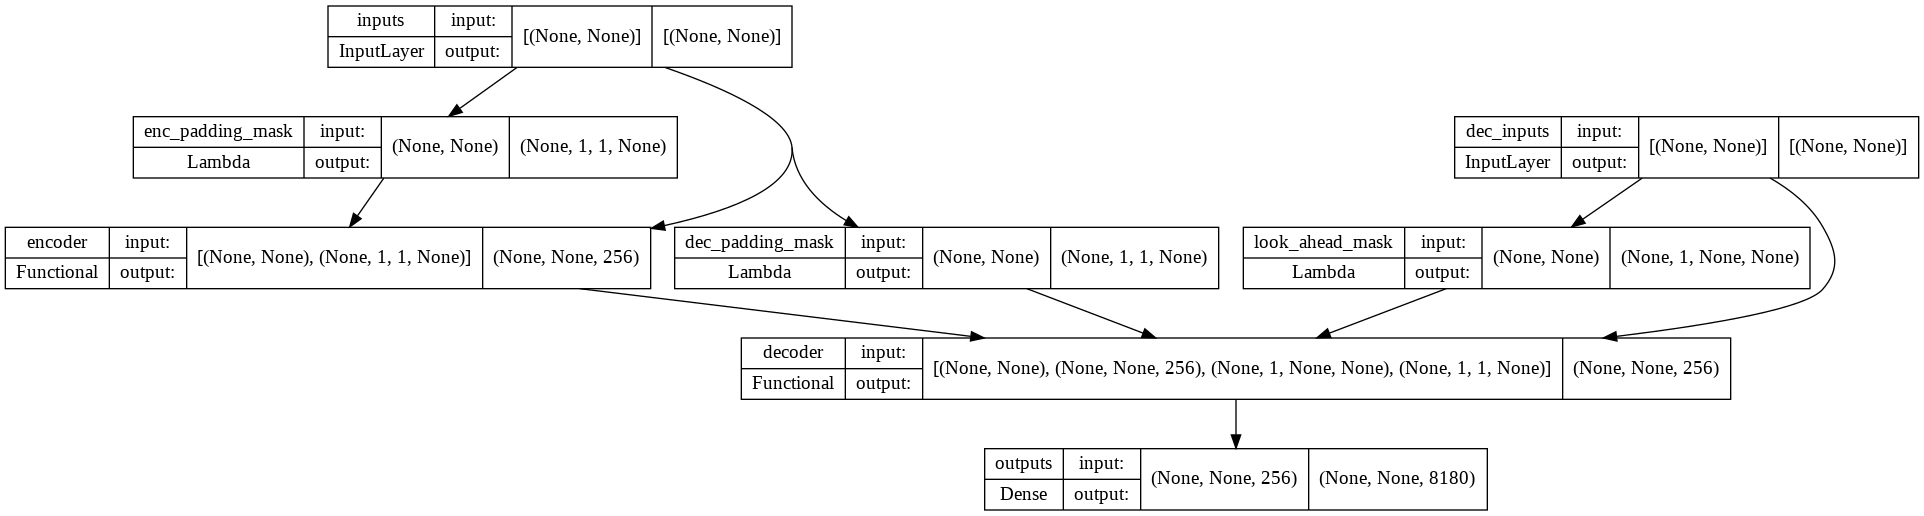

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

---
## 모델 학습

이제 위 트랜스포머 모델에 손실함수, 정확도 함수를 설정한후 모델 학습을 진행하겠다.


- 옵티마티저로 adam 을 사용했으며 $β_1=0.9, β_2
=0.98, 그리고  ϵ=10^{−9}$를 사용했다.
- 학습율은 학습시 가변적으로 변하도록 커스텀된 스캐줄을 적용하였다.

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


def accuracy(y_true, y_pred):  
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1)) # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 38s 121ms/step - loss: 1.4610 - accuracy: 0.0237
Epoch 2/50
185/185 [==============================] - 22s 119ms/step - loss: 1.1873 - accuracy: 0.0495
Epoch 3/50
185/185 [==============================] - 22s 119ms/step - loss: 1.0044 - accuracy: 0.0507
Epoch 4/50
185/185 [==============================] - 22s 121ms/step - loss: 0.9278 - accuracy: 0.0544
Epoch 5/50
185/185 [==============================] - 23s 122ms/step - loss: 0.8712 - accuracy: 0.0574
Epoch 6/50
185/185 [==============================] - 22s 121ms/step - loss: 0.8131 - accuracy: 0.0614
Epoch 7/50
185/185 [==============================] - 22s 121ms/step - loss: 0.7484 - accuracy: 0.0669
Epoch 8/50
185/185 [==============================] - 22s 121ms/step - loss: 0.6752 - accuracy: 0.0747
Epoch 9/50
185/185 [==============================] - 22s 120ms/step - loss: 0.5959 - accuracy: 0.0834
Epoch 10/50
185/185 [==============================] - 22s 120ms/step - l

---
## 챗봇 테스트


본 프로젝트의 챗봇 데이터는 연애나 일상이야기위주로 구성되어 있으므로 관련 질문들로 테스트를 진행해보겠다.

- decoder_inference
 - 입력문장을 전처리하여 정수시퀀스로 만듬.
 - 디코더를 통해 챗봇의 대답에 해당하는 단어를 순차적으로 예측.
 - 예측된 정수 시퀀스를 리턴

- sentence_generation
 - decoder_inference에서 반환된 시퀀스를 디코딩하여 문자시퀀스로 출력

In [ ]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측시작
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    
    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    # 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence


In [ ]:
sentence_generation('오늘 너무 춥다.')
print('-'*50)
sentence_generation('코로나때문에 걱정이 많아.')
print('-'*50)
sentence_generation('새로 나온 영화 같이 보러 갈까?')
print('-'*50)
sentence_generation('지금 고백해도될까?')
print('-'*50)
sentence_generation('오늘 점심에 뭐먹을까?')
print('-'*50)

입력 : 오늘 너무 춥다.
출력 : 따뜻하게 입으세요 .
--------------------------------------------------
입력 : 코로나때문에 걱정이 많아.
출력 : 동감입니다 .
--------------------------------------------------
입력 : 새로 나온 영화 같이 보러 갈까?
출력 : 좋은 생각만 하세요 .
--------------------------------------------------
입력 : 지금 고백해도될까?
출력 : 도전 정신 마음에 드네요 .
--------------------------------------------------
입력 : 오늘 점심에 뭐먹을까?
출력 : 맛있는 거 드세요 .
--------------------------------------------------


입력문장에대해 적절한 문장을 출력하는경우도 있고 엉뚱한 문장이 나오기도 한다. 

챗봇이 새로운 말을 만들어 내는지 기존에 저장된 문장을 그대로 뱉어 내는지도  확인해보자. 만약 기존의 문장이 아닌 말을 적절히 만든다면 트랜스포머 모델이 문장 생성에 효과적이라고 할수 있겠다. 

In [ ]:
sentence_generation('12시 땡!') #원본 QA내용 --> 12시 땡!,하루가 또 가네요.,0

입력 : 12시 땡!
출력 : 하루가 또 가네요 .


'하루가 또 가네요 .'

원본 내용에 대한 답변이 그대로 나온다. "12시땡!"과 같은 질문에 대한 답이 훈련데이터에 많지 않기 때문에 원본답변이 그대로 나온것 같다. 원본 질문데이터를 약간 바꾸어보자.

In [ ]:
sentence_generation('6시 땡!')

입력 : 6시 땡!
출력 : 축하해요 !


'축하해요 !'

6시땡이라는 질문은 없지만 "축하해요!"라는 말이 나왔다. 이것은 학습에 의한것인데 "6시"나 "땡"이라는 단어보다 "!"느낌표에 대한 학습한 결과로 "축하해요!"라는 답이 출력값으로 확율이 가장 높지 않았나 싶다.

In [ ]:
sentence_generation('6시 땡! 칼퇴하자') 

입력 : 6시 땡! 칼퇴하자
출력 : 미련을 천천히 다가가보세요 .


'미련을 천천히 다가가보세요 .'

"6시 땡!"뒤에 "칼퇴하자"라는 말은 붙여보았다. "칼퇴하자"라는 단어가 기존데이터셋에 없기때문에 자연스럽지 못한 문장이 나온것 같다. 

눈여겨 볼점은 단어들이 적절한 곳에 위치하고있다는 점이다. 목적어가 앞에 있고 동사가 뒤에 위치하는 것을 보면 학습을 통해 단어의 표시 순서나 품사의 활용법등을 익힌것으로 보인다.

마지막으로 단어사이의 유사도를 설명할때 나왔던 문장을 넣어보며 챗봇 테스트를 마치도록 하겠다.

In [ ]:
sentence_generation('그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다.') 

입력 : 그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다.
출력 : 좋아하는 만큼 감정 소모가 큰 건 없을 거예요 .


'좋아하는 만큼 감정 소모가 큰 건 없을 거예요 .'

---
# 정리.

- 이번 프로젝트에서는 트랜스포머 모델을 이용해 챗봇을 만들어 보았다. 이전 뉴스요약에서 썼던 seq2seq 모델에서도 attention을 사용했는데, 그 때는 RNN 내부에서 인코더측 입력시퀀스의 정보를 보완하여 디코더와 연결하기위해 어텐션을 썼다면 이번 프로젝트에서는 RNN 계열의 레이어 없이 어텐션만으로 인코더와 디코더를 만든점이 특징이였다. 또한 RNN 계열의 레이어를 쓰지않기 때문에 순차적인 정보를 포지셔널 인코딩을 통해 처리했다.


- 트랜스포머에서는 seq2seq 모델에서보았던 인코더, 디코더 구조가 점점 더 확장되는 모습이다. 어텐션 메커니즘과 관련하여 마스크, Q,K,V행렬의 계산, 스케일닷프로덕트 같은 부분은 이해하기 어려워 개략적인 차원에서 흐름만 파악하였다. 단어들에 의미를 부여하기위해 단어중 포함된 패딩을 마스크를 사용하여 의미를 줄이고, Q,K,V를 행렬을 통해 관심을 둘 단어의 수치를 계산하는 방식이 흥미로웠다. 멀티헤드어텐션을 통해 병렬처리를 지원하여 RNN, CNN보다 속도또한 빨라
질뿐만아니라 어텐션의 효과 또한 좋다고하니 어텐션이 만능인듯하다. 

- **Attention is All I hove to know!** 어텐션에 대해 다시보았지만 아직 익숙해지려면 더 오랜기간이 걸릴것 같다. 앞으로 각 모듈들을 다른 모델에 연결하거나 재구조화 하는 과정이 있을것이므로 각 모듈의 쓰임을 잘알아두어야하겠다.  



- 테스트 결과에 대한 고찰
 -  LMS노드에서 self-attention을 설명하기위해 들었던 예시에서 "그것"과 "동물"을 연결한다고 했는데 제대로 대명사가 지칭하는 명사에 집중하고 있는지 의문이 든다. 
 
 - raw 데이터에 비슷한 질문이 있는 경우는 모델이 생성한 문장이 자연스러웠지만(그문장 그대로를 가져옴.) 그렇지 않은 질문에 대한 답은 의미가 통하지 않는 경우가 많았다.
 
 - 하지만 서브워드에 의해 나누어졌던 조사나 명사들이(수_', '게_', '너무_', '더_', '거_' 등) 적절한 위치에 정렬되었다.



---
## Reference
- [positional encoding이란 무엇인가](https://skyjwoo.tistory.com/entry/positional-encoding%EC%9D%B4%EB%9E%80-%EB%AC%B4%EC%97%87%EC%9D%B8%EA%B0%80)

- [The Illustrated Transformer](https://nlpinkorean.github.io/illustrated-transformer/)

- [논문 뽀개기-Attention is All You Need](https://catsirup.github.io/ai/2020/04/07/transformer.html)

